In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df1 = pd.read_csv('/content/Data_80m_wind.csv')
df2 = pd.read_csv('/content/Data_100m_wind.csv')
df3 = pd.read_csv('/content/Data_120m_wind.csv')
df4 = pd.read_csv('/content/Data_140m_wind.csv')
df5 = pd.read_csv('/content/Data_160m_wind.csv')
df6 = pd.read_csv('/content/Data_180m_wind.csv')
df7 = pd.read_csv('/content/Data_200m_wind.csv')

In [4]:
df1.head()

,Date/Time,80m Wind Speed [m/s]
0,01-12-2018 00:10,8.73
1,01-12-2018 00:20,8.50
2,01-12-2018 00:30,8.77
3,01-12-2018 00:40,8.22
4,01-12-2018 00:50,8.31


# **80m**

In [5]:
from sklearn.impute import KNNImputer
import pandas as pd

# Assuming 'df' is your DataFrame

n_neighbors = 5  # Number of neighbors to consider. Adjust based on your dataset size and characteristics

imputer = KNNImputer(n_neighbors=n_neighbors)
# It's recommended to normalize or standardize your data before using KNN imputation for better performance
# Here, we are imputing directly for simplicity
imputed_values = imputer.fit_transform(df1[['80m Wind Speed [m/s]']])

# Replace the original column with the imputed values
df1['80m Wind Speed [m/s]'] = imputed_values



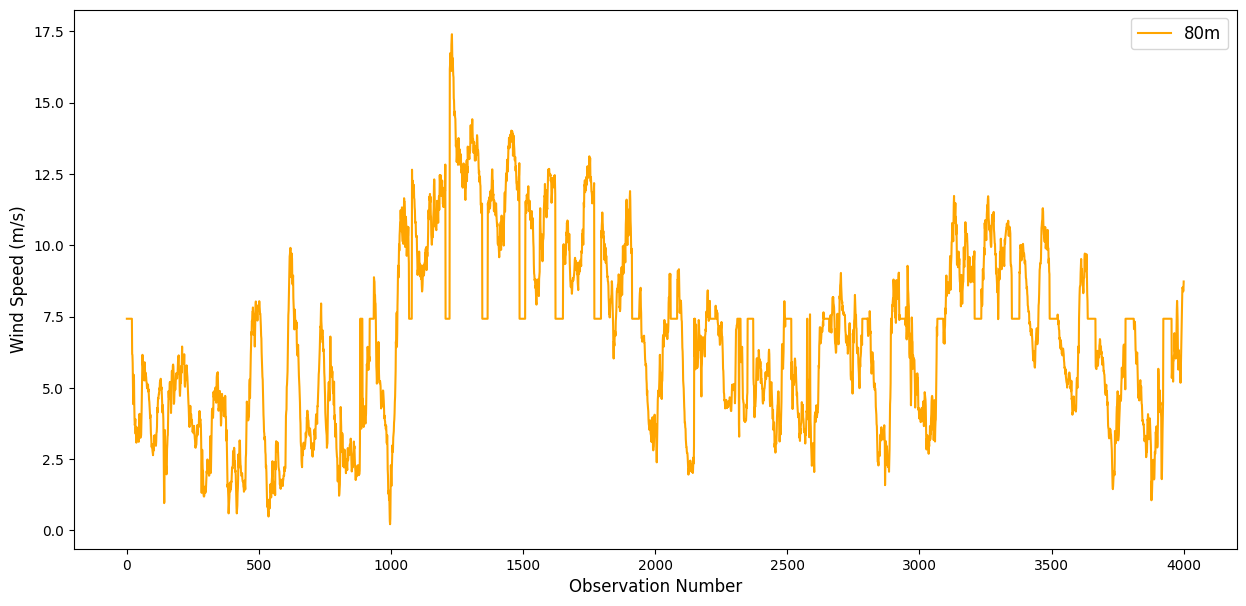

In [6]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it contains a column 'Wind Speed [m/s]' for wind speed
# Extracting the first 4000 observations
wind_speed_data = df1['80m Wind Speed [m/s]'][700:4700]

# Generating a sequence of observation numbers starting from 1
observation_numbers = range(1, 4001)

# Plotting the graph
plt.figure(figsize=(15, 7))  # Set the figure size as desired
plt.plot(observation_numbers, wind_speed_data, label='80m', color='orange')  # Specify the color as needed

# Labeling the axes
plt.xlabel('Observation Number', fontsize='large')
plt.ylabel('Wind Speed (m/s)', fontsize='large')

# Adding the legend
plt.legend(fontsize = 'large')

# Optionally, you can adjust the tick frequency on the x-axis for better readability
plt.xticks(range(0, 4001, 500))

# Showing the plot
plt.show()


In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Assuming 'df' is your DataFrame
data = df1['80m Wind Speed [m/s]'].values.reshape(-1,1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Function to create dataset with look-back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Split data into training and testing
look_back = 1
X, Y = create_dataset(data_scaled, look_back)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the Stacked LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(50, return_sequences=False))  # Stacking another LSTM layer
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=2, verbose=2)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform for original scale
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test])

# Calculate MAE
mae = mean_absolute_error(y_test_inv.flatten(), test_predict.flatten())
print(f'MAE: {mae:.4f}')

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test_inv.flatten(), test_predict.flatten()))
print(f'RMSE: {rmse:.4f}')

# Calculate MAPE
mape = np.mean(np.abs((y_test_inv.flatten() - test_predict.flatten()) / y_test_inv.flatten())) * 100
print(f'MAPE: {mape:.4f}%')

from sklearn.metrics import r2_score

# Calculate R^2 score for the test set
r2_test = r2_score(y_test_inv.flatten(), test_predict.flatten())
print(f'Test R^2 Score: {r2_test:.4f}')

Epoch 1/5
21023/21023 - 100s - loss: 0.0013 - 100s/epoch - 5ms/step
Epoch 2/5
21023/21023 - 91s - loss: 0.0010 - 91s/epoch - 4ms/step
Epoch 3/5
21023/21023 - 92s - loss: 9.8804e-04 - 92s/epoch - 4ms/step
Epoch 4/5
21023/21023 - 91s - loss: 9.7359e-04 - 91s/epoch - 4ms/step
Epoch 5/5
21023/21023 - 90s - loss: 9.6682e-04 - 90s/epoch - 4ms/step
329/329 [==============================] - 1s 2ms/step
MAE: 0.3860
RMSE: 0.5989
MAPE: 8.1183%
Test R^2 Score: 0.9469


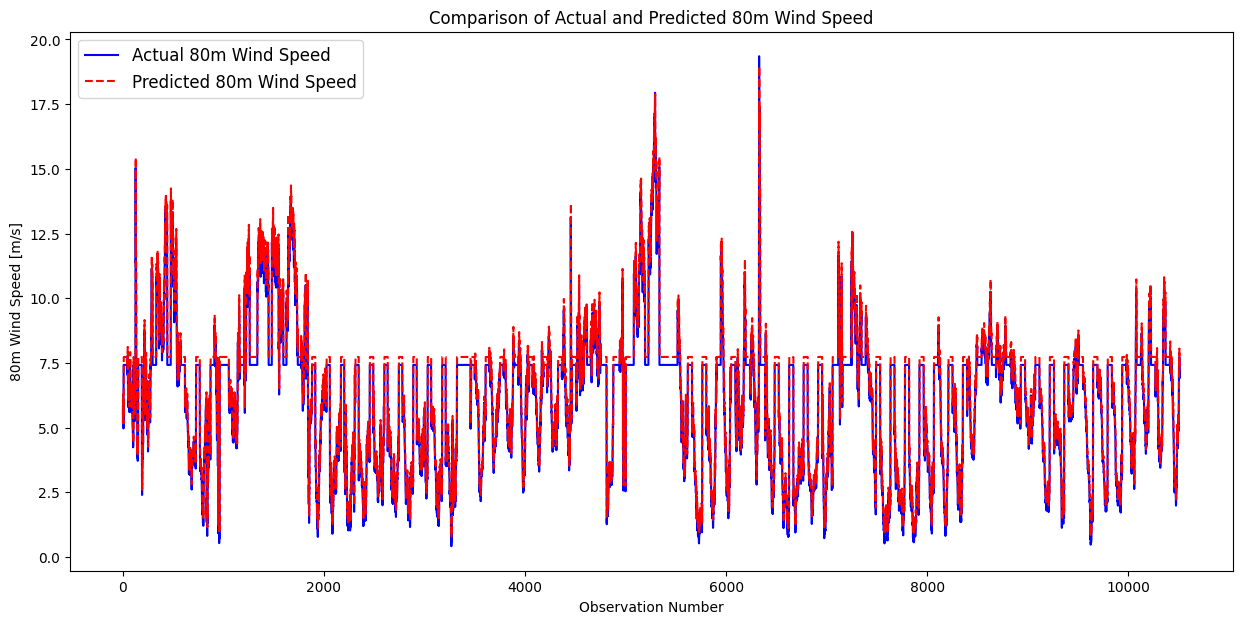

In [10]:
import matplotlib.pyplot as plt

# Generate a sequence of indices for plotting - adjust based on the number of test samples
indices = range(len(y_test_inv.flatten()))

# Plotting
plt.figure(figsize=(15, 7))
# Plotting the original dataset values
plt.plot(indices, y_test_inv.flatten(), label='Actual 80m Wind Speed', color='blue')
# Plotting the model predictions
plt.plot(indices, test_predict.flatten(), label='Predicted 80m Wind Speed', color='red', linestyle='--')

# Adding title and labels
plt.title('Comparison of Actual and Predicted 80m Wind Speed')
plt.xlabel('Observation Number')
plt.ylabel('80m Wind Speed [m/s]')

# Adding a legend
plt.legend(loc='upper left', fontsize='large')

plt.show()


# **100m**

In [3]:
from sklearn.impute import KNNImputer
import pandas as pd

# Assuming 'df' is your DataFrame

n_neighbors = 5  # Number of neighbors to consider. Adjust based on your dataset size and characteristics

imputer = KNNImputer(n_neighbors=n_neighbors)
# It's recommended to normalize or standardize your data before using KNN imputation for better performance
# Here, we are imputing directly for simplicity
imputed_values = imputer.fit_transform(df2[['100m Wind Speed [m/s]']])

# Replace the original column with the imputed values
df2['100m Wind Speed [m/s]'] = imputed_values


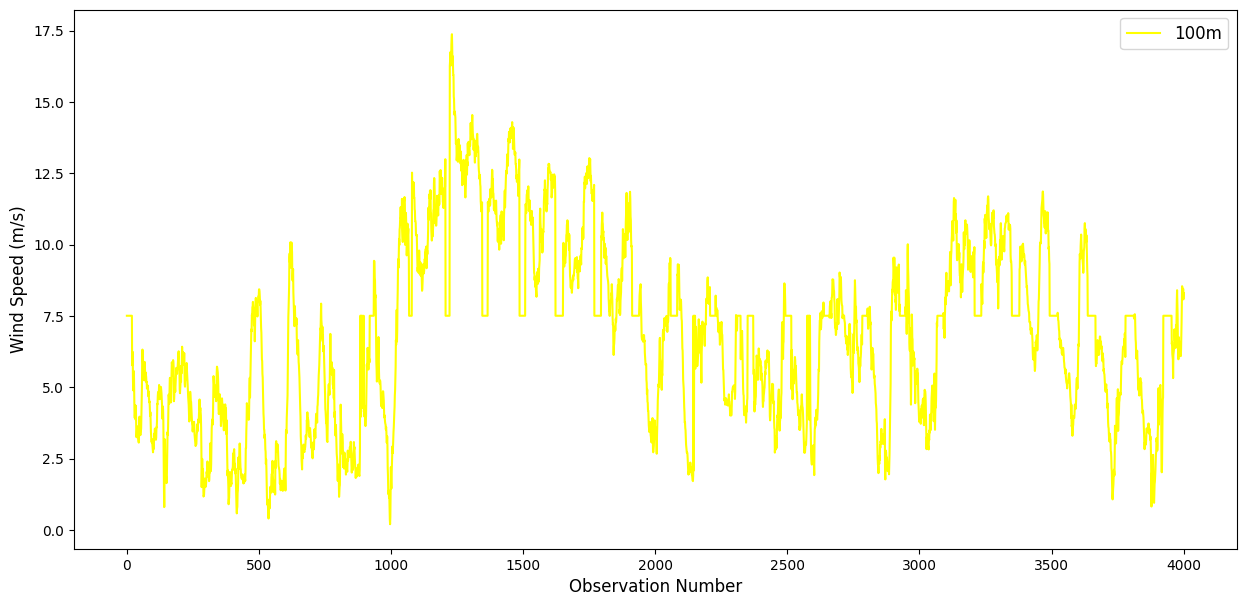

In [36]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it contains a column 'Wind Speed [m/s]' for wind speed
# Extracting the first 4000 observations
wind_speed_data = df2['100m Wind Speed [m/s]'][700:4700]

# Generating a sequence of observation numbers starting from 1
observation_numbers = range(1, 4001)

# Plotting the graph
plt.figure(figsize=(15, 7))  # Set the figure size as desired
plt.plot(observation_numbers, wind_speed_data, label='100m', color='yellow')  # Specify the color as needed

# Labeling the axes
plt.xlabel('Observation Number', fontsize='large')
plt.ylabel('Wind Speed (m/s)', fontsize='large')

# Adding the legend
plt.legend(fontsize = 'large')

# Optionally, you can adjust the tick frequency on the x-axis for better readability
plt.xticks(range(0, 4001, 500))

# Showing the plot
plt.show()


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Assuming 'df' is your DataFrame
data = df2['100m Wind Speed [m/s]'].values.reshape(-1,1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Function to create dataset for ConvLSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Split data into training and testing
look_back = 1
X, Y = create_dataset(data_scaled, look_back)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

# Reshape input to be [samples, time steps, 1, 1, features] for ConvLSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, 1, 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 1, 1, X_test.shape[1]))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense, Flatten

# Build the ConvLSTM model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, look_back)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=2, verbose=2)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform for original scale
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test])

# Calculate MAE
mae = mean_absolute_error(y_test_inv.flatten(), test_predict.flatten())
print(f'MAE: {mae:.4f}')

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test_inv.flatten(), test_predict.flatten()))
print(f'RMSE: {rmse:.4f}')

# Calculate MAPE
mape = np.mean(np.abs((y_test_inv.flatten() - test_predict.flatten()) / y_test_inv.flatten())) * 100
print(f'MAPE: {mape:.4f}%')

from sklearn.metrics import r2_score

# Inverse transform of y_test if it was scaled
y_test_inv = scaler.inverse_transform([y_test])

# Calculate R^2 score
r_squared = r2_score(y_test_inv.flatten(), test_predict.flatten())
print(f'R^2 Score: {r_squared:.4f}')


Epoch 1/5
21023/21023 - 146s - loss: 0.0014 - 146s/epoch - 7ms/step
Epoch 2/5
21023/21023 - 141s - loss: 8.5858e-04 - 141s/epoch - 7ms/step
Epoch 3/5
21023/21023 - 126s - loss: 8.5655e-04 - 126s/epoch - 6ms/step
Epoch 4/5
21023/21023 - 125s - loss: 8.5225e-04 - 125s/epoch - 6ms/step
Epoch 5/5
21023/21023 - 124s - loss: 8.5241e-04 - 124s/epoch - 6ms/step
329/329 [==============================] - 1s 3ms/step
MAE: 0.2878
RMSE: 0.5248
MAPE: 7.1485%
R^2 Score: 0.9602


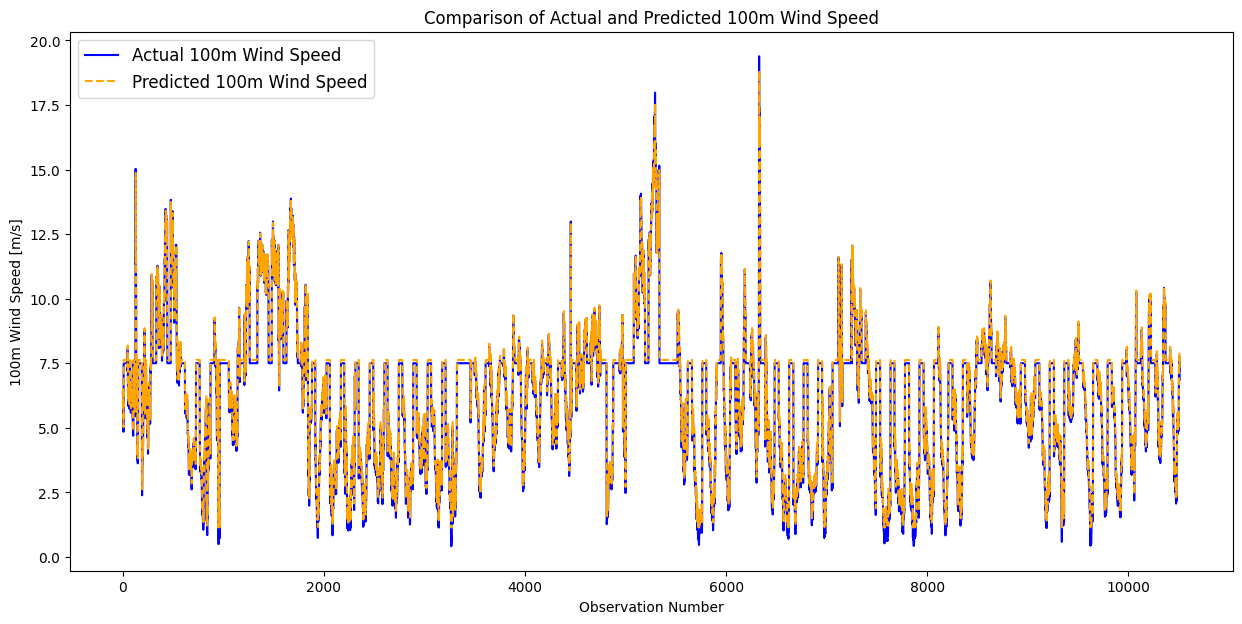

In [6]:
import matplotlib.pyplot as plt

# Generate a sequence of indices for plotting - adjust based on the number of test samples
indices = range(len(y_test_inv.flatten()))

# Plotting
plt.figure(figsize=(15, 7))
# Plotting the original dataset values
plt.plot(indices, y_test_inv.flatten(), label='Actual 100m Wind Speed', color='blue')
# Plotting the model predictions
plt.plot(indices, test_predict.flatten(), label='Predicted 100m Wind Speed', color='orange', linestyle='--')

# Adding title and labels
plt.title('Comparison of Actual and Predicted 100m Wind Speed')
plt.xlabel('Observation Number')
plt.ylabel('100m Wind Speed [m/s]')

# Adding a legend
plt.legend(loc='upper left', fontsize='large')

plt.show()


# **120m**

In [7]:
from sklearn.impute import KNNImputer
import pandas as pd

# Assuming 'df' is your DataFrame

n_neighbors = 5  # Number of neighbors to consider. Adjust based on your dataset size and characteristics

imputer = KNNImputer(n_neighbors=n_neighbors)
# It's recommended to normalize or standardize your data before using KNN imputation for better performance
# Here, we are imputing directly for simplicity
imputed_values = imputer.fit_transform(df3[['120m Wind Speed [m/s]']])

# Replace the original column with the imputed values
df3['120m Wind Speed [m/s]'] = imputed_values


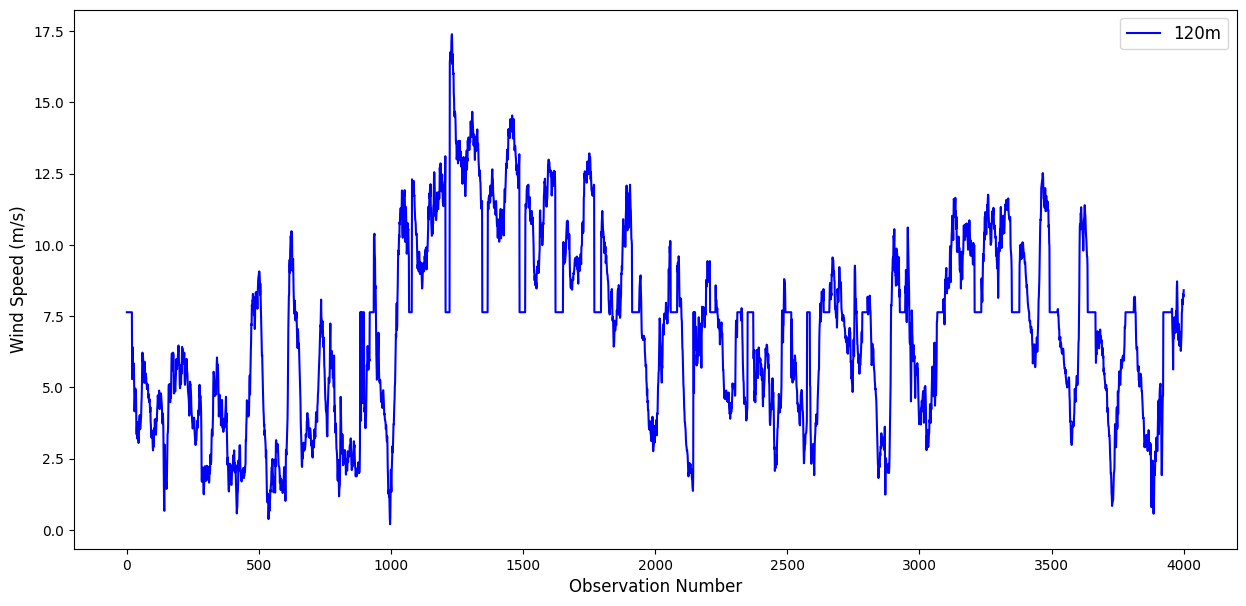

In [37]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it contains a column 'Wind Speed [m/s]' for wind speed
# Extracting the first 4000 observations
wind_speed_data = df3['120m Wind Speed [m/s]'][700:4700]

# Generating a sequence of observation numbers starting from 1
observation_numbers = range(1, 4001)

# Plotting the graph
plt.figure(figsize=(15, 7))  # Set the figure size as desired
plt.plot(observation_numbers, wind_speed_data, label='120m', color='blue')  # Specify the color as needed

# Labeling the axes
plt.xlabel('Observation Number', fontsize='large')
plt.ylabel('Wind Speed (m/s)', fontsize='large')

# Adding the legend
plt.legend(fontsize = 'large')

# Optionally, you can adjust the tick frequency on the x-axis for better readability
plt.xticks(range(0, 4001, 500))

# Showing the plot
plt.show()

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Assuming 'df' is your DataFrame
data = df3['120m Wind Speed [m/s]'].values.reshape(-1,1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Function to create dataset for ConvLSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Split data into training and testing
look_back = 1
X, Y = create_dataset(data_scaled, look_back)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

# Reshape input to be [samples, time steps, 1, 1, features] for ConvLSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, 1, 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 1, 1, X_test.shape[1]))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense, Flatten

# Build the ConvLSTM model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, look_back)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=2, verbose=2)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform for original scale
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test])

# Calculate MAE
mae = mean_absolute_error(y_test_inv.flatten(), test_predict.flatten())
print(f'MAE: {mae:.4f}')

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test_inv.flatten(), test_predict.flatten()))
print(f'RMSE: {rmse:.4f}')

# Calculate MAPE
mape = np.mean(np.abs((y_test_inv.flatten() - test_predict.flatten()) / y_test_inv.flatten())) * 100
print(f'MAPE: {mape:.4f}%')

from sklearn.metrics import r2_score

# Inverse transform of y_test if it was scaled
y_test_inv = scaler.inverse_transform([y_test])

# Calculate R^2 score
r_squared = r2_score(y_test_inv.flatten(), test_predict.flatten())
print(f'R^2 Score: {r_squared:.4f}')


Epoch 1/5
21023/21023 - 146s - loss: 0.0013 - 146s/epoch - 7ms/step
Epoch 2/5
21023/21023 - 129s - loss: 8.5428e-04 - 129s/epoch - 6ms/step
Epoch 3/5
21023/21023 - 128s - loss: 8.4833e-04 - 128s/epoch - 6ms/step
Epoch 4/5
21023/21023 - 129s - loss: 8.4858e-04 - 129s/epoch - 6ms/step
Epoch 5/5
21023/21023 - 130s - loss: 8.4648e-04 - 130s/epoch - 6ms/step
329/329 [==============================] - 1s 2ms/step
MAE: 0.2877
RMSE: 0.5267
MAPE: 6.9233%
R^2 Score: 0.9610


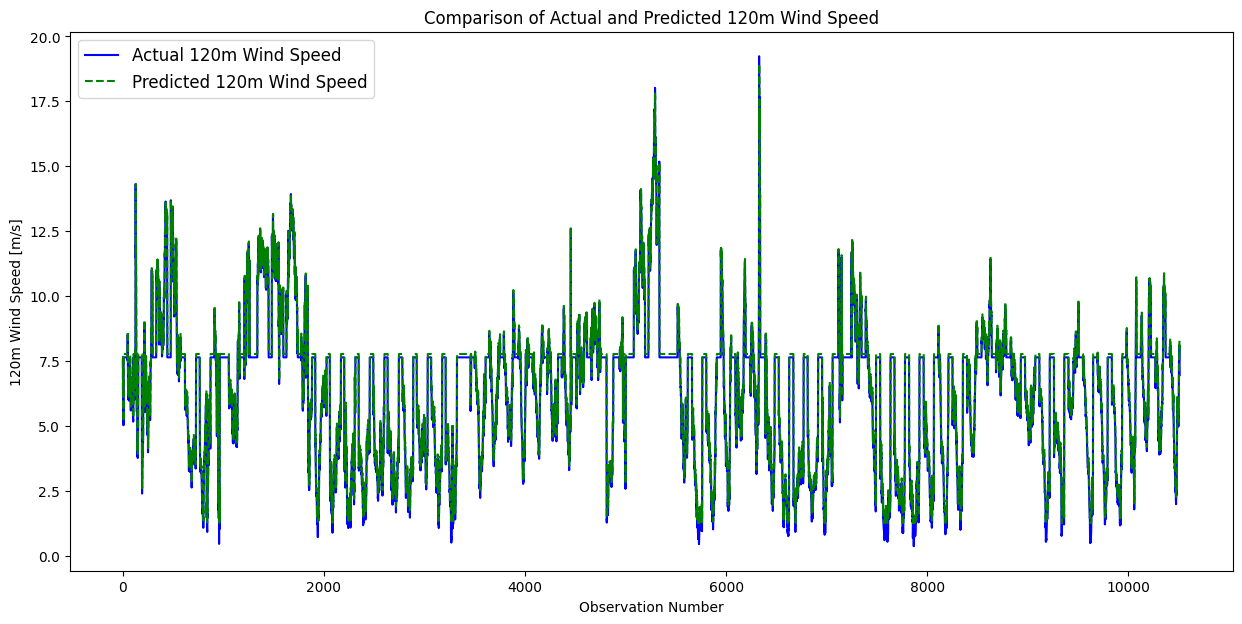

In [9]:
import matplotlib.pyplot as plt

# Generate a sequence of indices for plotting - adjust based on the number of test samples
indices = range(len(y_test_inv.flatten()))

# Plotting
plt.figure(figsize=(15, 7))
# Plotting the original dataset values
plt.plot(indices, y_test_inv.flatten(), label='Actual 120m Wind Speed', color='blue')
# Plotting the model predictions
plt.plot(indices, test_predict.flatten(), label='Predicted 120m Wind Speed', color='green', linestyle='--')

# Adding title and labels
plt.title('Comparison of Actual and Predicted 120m Wind Speed')
plt.xlabel('Observation Number')
plt.ylabel('120m Wind Speed [m/s]')

# Adding a legend
plt.legend(loc='upper left', fontsize='large')

plt.show()


# **140m**

In [3]:
from sklearn.impute import KNNImputer
import pandas as pd

# Assuming 'df' is your DataFrame

n_neighbors = 5  # Number of neighbors to consider. Adjust based on your dataset size and characteristics

imputer = KNNImputer(n_neighbors=n_neighbors)
# It's recommended to normalize or standardize your data before using KNN imputation for better performance
# Here, we are imputing directly for simplicity
imputed_values = imputer.fit_transform(df4[['140m Wind Speed [m/s]']])

# Replace the original column with the imputed values
df4['140m Wind Speed [m/s]'] = imputed_values


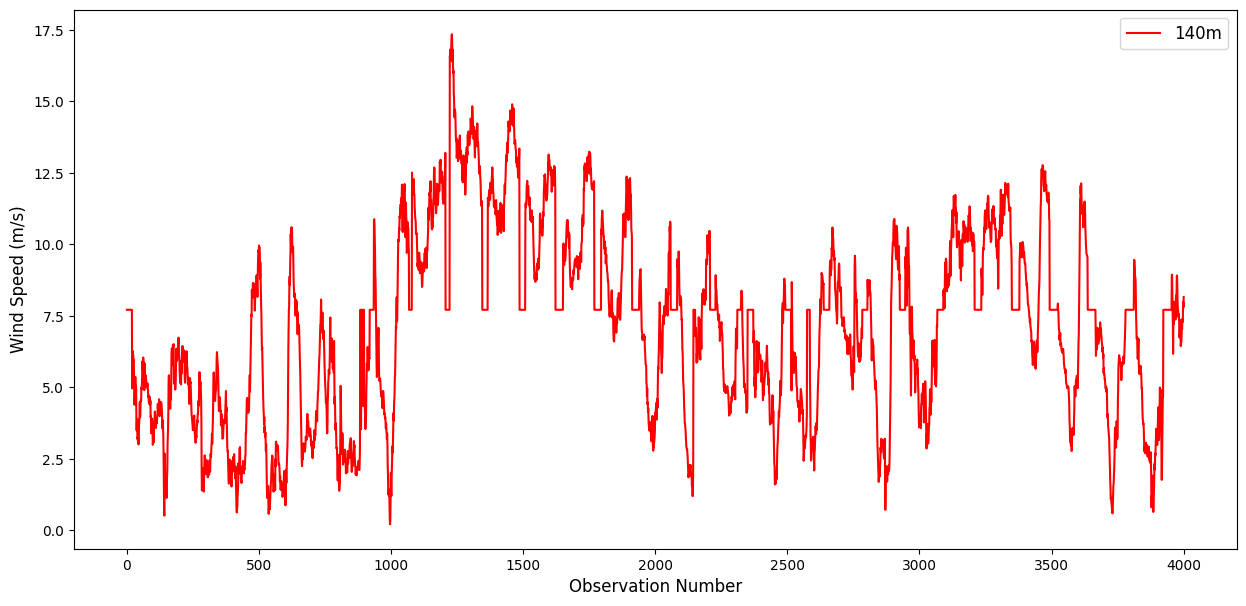

In [38]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it contains a column 'Wind Speed [m/s]' for wind speed
# Extracting the first 4000 observations
wind_speed_data = df4['140m Wind Speed [m/s]'][700:4700]

# Generating a sequence of observation numbers starting from 1
observation_numbers = range(1, 4001)

# Plotting the graph
plt.figure(figsize=(15, 7))  # Set the figure size as desired
plt.plot(observation_numbers, wind_speed_data, label='140m', color='red')  # Specify the color as needed

# Labeling the axes
plt.xlabel('Observation Number', fontsize='large')
plt.ylabel('Wind Speed (m/s)', fontsize='large')

# Adding the legend
plt.legend(fontsize = 'large')

# Optionally, you can adjust the tick frequency on the x-axis for better readability
plt.xticks(range(0, 4001, 500))

# Showing the plot
plt.show()

In [6]:
# prompt: give same code as above for bi lstm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
# Sample data loading step
# df = pd.read_csv('your_data.csv')  # Make sure to load your dataset here

# Assuming '40m Wind Speed [m/s]' is the column you're interested in
data = df4['140m Wind Speed [m/s]'].values.reshape(-1, 1)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Split data into training and test sets in an 80:20 ratio
split_idx = int(len(data_scaled) * 0.8)
train, test = data_scaled[:split_idx, :], data_scaled[split_idx:, :]

# Function to create dataset for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build the Bi-LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(50, input_shape=(1, look_back))))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
model.fit(X_train, y_train, epochs=5, batch_size=2, verbose=2)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test])

# Calculate MAPE
mape_test = mean_absolute_percentage_error(y_test_inv.flatten(), test_predict.flatten()) * 100
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from math import sqrt

# Assuming y_test_inv and test_predict are your actual and predicted values respectively and have been inverse transformed to their original scale

# Calculate MAE
mae_test = mean_absolute_error(y_test_inv.flatten(), test_predict.flatten())

# Calculate RMSE
rmse_test = sqrt(mean_squared_error(y_test_inv.flatten(), test_predict.flatten()))

# Calculate MAPE
mape_test = mean_absolute_percentage_error(y_test_inv.flatten(), test_predict.flatten()) * 100

print(f'Test MAE: {mae_test:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')
print(f'Test MAPE: {mape_test:.4f}%')
from sklearn.metrics import r2_score

# Calculate R^2 score for the test set
r2_test = r2_score(y_test_inv.flatten(), test_predict.flatten())
print(f'Test R^2 Score: {r2_test:.4f}')



Epoch 1/5
21023/21023 - 58s - loss: 0.0011 - 58s/epoch - 3ms/step
Epoch 2/5
21023/21023 - 50s - loss: 8.7875e-04 - 50s/epoch - 2ms/step
Epoch 3/5
21023/21023 - 47s - loss: 8.7015e-04 - 47s/epoch - 2ms/step
Epoch 4/5
21023/21023 - 47s - loss: 8.6397e-04 - 47s/epoch - 2ms/step
Epoch 5/5
21023/21023 - 45s - loss: 8.6197e-04 - 45s/epoch - 2ms/step
329/329 [==============================] - 1s 2ms/step


NameError: name 'mean_absolute_percentage_error' is not defined

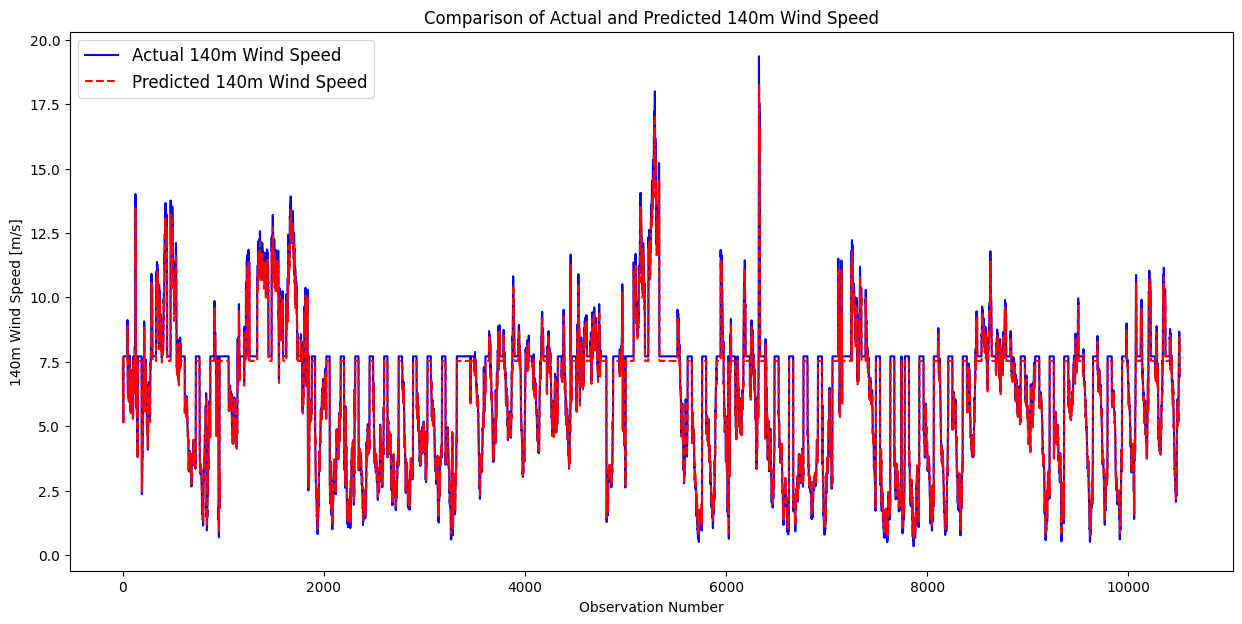

In [7]:
import matplotlib.pyplot as plt


# Generate a sequence of indices for plotting - adjust based on the number of test samples
indices = range(len(y_test_inv.flatten()))

# Plotting
plt.figure(figsize=(15, 7))
# Plotting the original dataset values
plt.plot(indices, y_test_inv.flatten(), label='Actual 140m Wind Speed', color='blue')
# Plotting the model predictions
plt.plot(indices, test_predict.flatten(), label='Predicted 140m Wind Speed', color='red', linestyle='--')

# Adding title and labels
plt.title('Comparison of Actual and Predicted 140m Wind Speed')
plt.xlabel('Observation Number')
plt.ylabel('140m Wind Speed [m/s]')

# Adding a legend
plt.legend(loc='upper left', fontsize='large')

plt.show()


# **160m**

In [8]:
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Assuming 'df' is your DataFrame

n_neighbors = 5  # Number of neighbors to consider. Adjust based on your dataset size and characteristics

imputer = KNNImputer(n_neighbors=n_neighbors)
# It's recommended to normalize or standardize your data before using KNN imputation for better performance
# Here, we are imputing directly for simplicity
imputed_values = imputer.fit_transform(df5[['160m Wind Speed [m/s]']])

# Replace the original column with the imputed values
df5['160m Wind Speed [m/s]'] = imputed_values


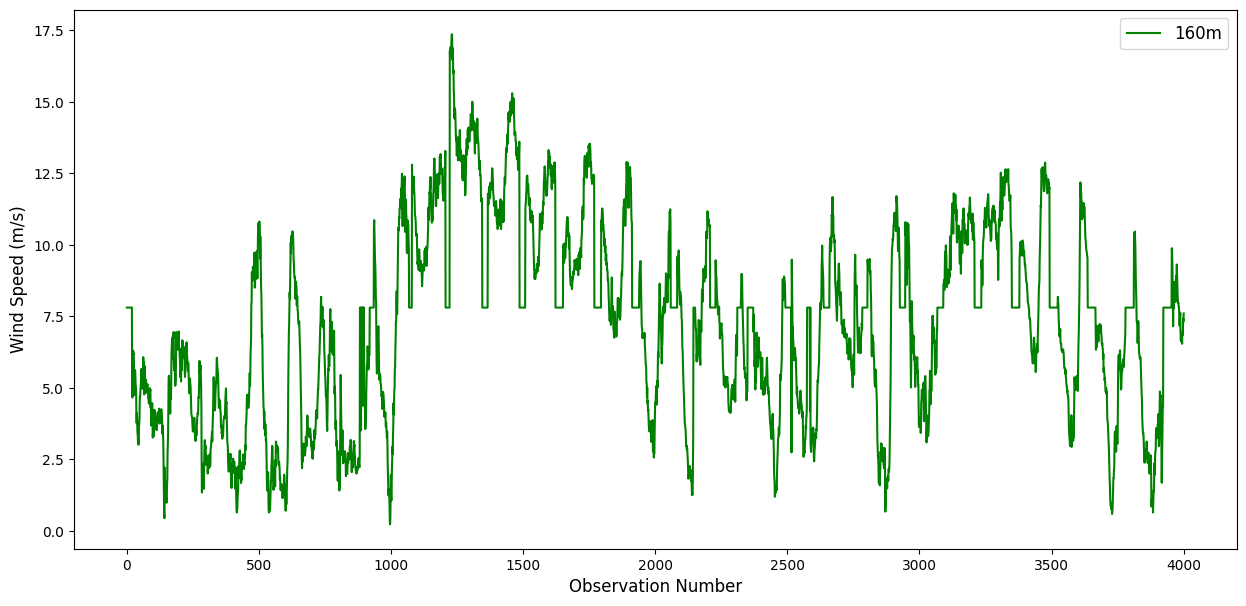

In [9]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it contains a column 'Wind Speed [m/s]' for wind speed
# Extracting the first 4000 observations
wind_speed_data = df5['160m Wind Speed [m/s]'][700:4700]

# Generating a sequence of observation numbers starting from 1
observation_numbers = range(1, 4001)

# Plotting the graph
plt.figure(figsize=(15, 7))  # Set the figure size as desired
plt.plot(observation_numbers, wind_speed_data, label='160m', color='green')  # Specify the color as needed

# Labeling the axes
plt.xlabel('Observation Number', fontsize='large')
plt.ylabel('Wind Speed (m/s)', fontsize='large')

# Adding the legend
plt.legend(fontsize = 'large')

# Optionally, you can adjust the tick frequency on the x-axis for better readability
plt.xticks(range(0, 4001, 500))

# Showing the plot
plt.show()

In [10]:
# prompt: give same code as above for bi lstm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
from sklearn.metrics import mean_absolute_percentage_error
# Sample data loading step
# df = pd.read_csv('your_data.csv')  # Make sure to load your dataset here

# Assuming '40m Wind Speed [m/s]' is the column you're interested in
data = df5['160m Wind Speed [m/s]'].values.reshape(-1, 1)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Split data into training and test sets in an 80:20 ratio
split_idx = int(len(data_scaled) * 0.8)
train, test = data_scaled[:split_idx, :], data_scaled[split_idx:, :]

# Function to create dataset for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build the Bi-LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(50, input_shape=(1, look_back))))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
model.fit(X_train, y_train, epochs=5, batch_size=2, verbose=2)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test])

# Calculate MAPE
mape_test = mean_absolute_percentage_error(y_test_inv.flatten(), test_predict.flatten()) * 100
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from math import sqrt

# Assuming y_test_inv and test_predict are your actual and predicted values respectively and have been inverse transformed to their original scale

# Calculate MAE
mae_test = mean_absolute_error(y_test_inv.flatten(), test_predict.flatten())

# Calculate RMSE
rmse_test = sqrt(mean_squared_error(y_test_inv.flatten(), test_predict.flatten()))

# Calculate MAPE
mape_test = mean_absolute_percentage_error(y_test_inv.flatten(), test_predict.flatten()) * 100

print(f'Test MAE: {mae_test:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')
print(f'Test MAPE: {mape_test:.4f}%')
from sklearn.metrics import r2_score

# Calculate R^2 score for the test set
r2_test = r2_score(y_test_inv.flatten(), test_predict.flatten())
print(f'Test R^2 Score: {r2_test:.4f}')



Epoch 1/5
21023/21023 - 64s - loss: 0.0011 - 64s/epoch - 3ms/step
Epoch 2/5
21023/21023 - 48s - loss: 8.8705e-04 - 48s/epoch - 2ms/step
Epoch 3/5
21023/21023 - 47s - loss: 8.7856e-04 - 47s/epoch - 2ms/step
Epoch 4/5
21023/21023 - 46s - loss: 8.7314e-04 - 46s/epoch - 2ms/step
Epoch 5/5
21023/21023 - 47s - loss: 8.6878e-04 - 47s/epoch - 2ms/step
329/329 [==============================] - 1s 2ms/step


NameError: name 'mean_absolute_percentage_error' is not defined

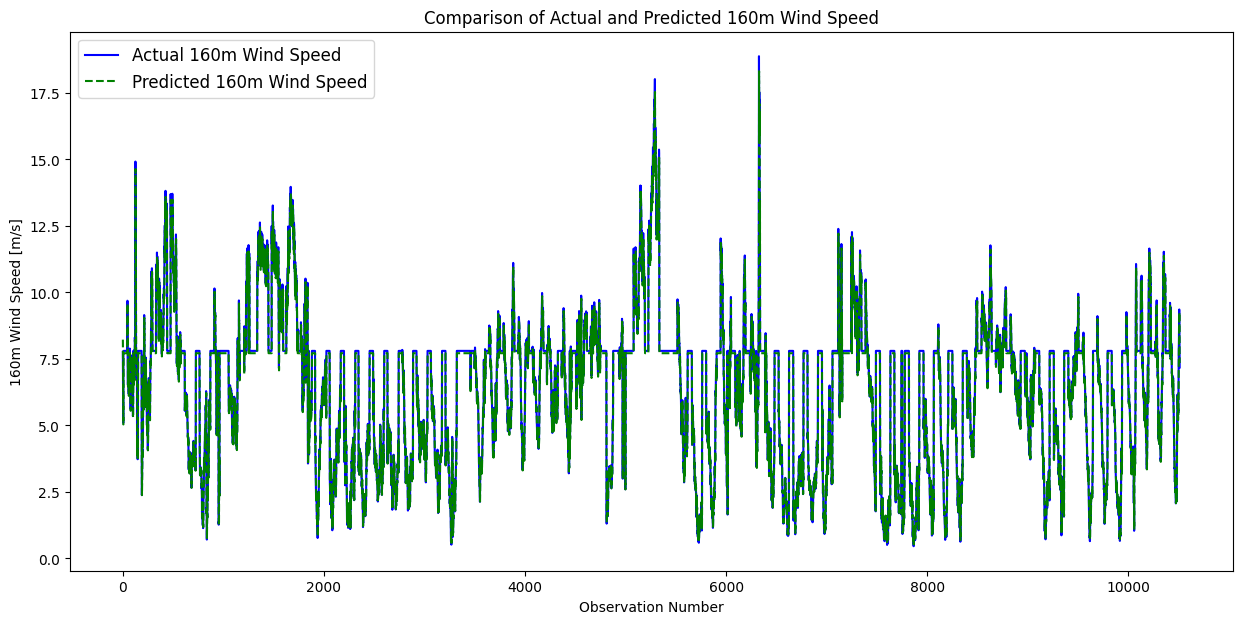

In [11]:
import matplotlib.pyplot as plt

# Generate a sequence of indices for plotting - adjust based on the number of test samples
indices = range(len(y_test_inv.flatten()))

# Plotting
plt.figure(figsize=(15, 7))
# Plotting the original dataset values
plt.plot(indices, y_test_inv.flatten(), label='Actual 160m Wind Speed', color='blue')
# Plotting the model predictions
plt.plot(indices, test_predict.flatten(), label='Predicted 160m Wind Speed', color='green', linestyle='--')

# Adding title and labels
plt.title('Comparison of Actual and Predicted 160m Wind Speed')
plt.xlabel('Observation Number')
plt.ylabel('160m Wind Speed [m/s]')

# Adding a legend
plt.legend(loc='upper left', fontsize='large')

plt.show()


# **180m**

In [12]:
from sklearn.impute import KNNImputer
import pandas as pd

# Assuming 'df' is your DataFrame

n_neighbors = 5  # Number of neighbors to consider. Adjust based on your dataset size and characteristics

imputer = KNNImputer(n_neighbors=n_neighbors)
# It's recommended to normalize or standardize your data before using KNN imputation for better performance
# Here, we are imputing directly for simplicity
imputed_values = imputer.fit_transform(df6[['180m Wind Speed [m/s]']])

# Replace the original column with the imputed values
df6['180m Wind Speed [m/s]'] = imputed_values


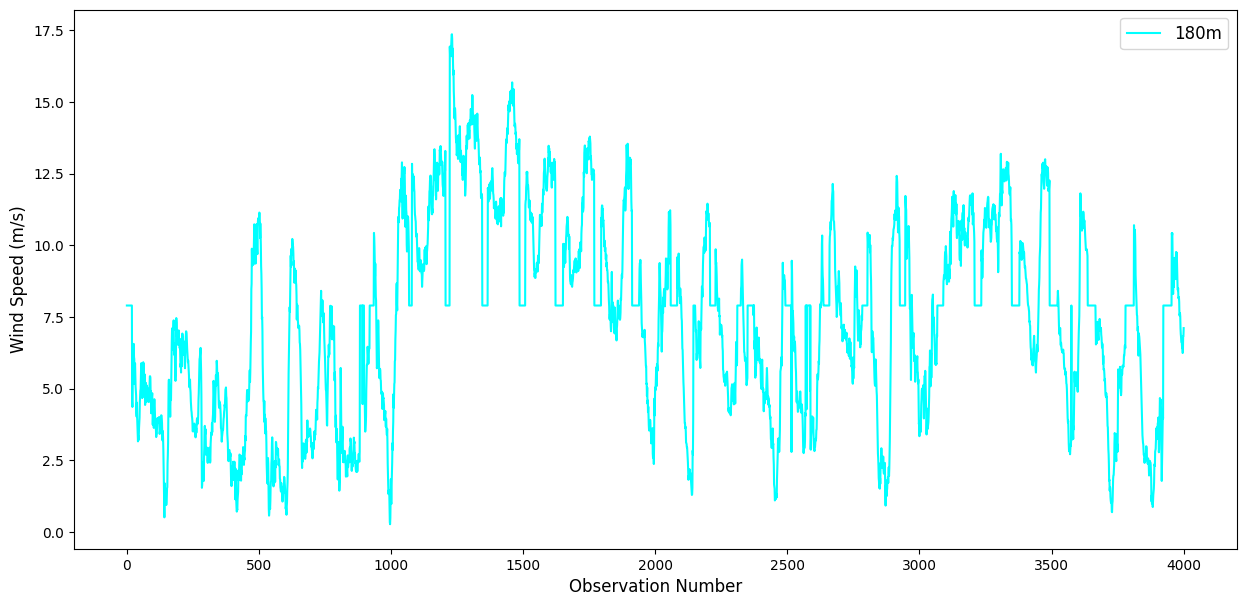

In [40]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it contains a column 'Wind Speed [m/s]' for wind speed
# Extracting the first 4000 observations
wind_speed_data = df6['180m Wind Speed [m/s]'][700:4700]

# Generating a sequence of observation numbers starting from 1
observation_numbers = range(1, 4001)

# Plotting the graph
plt.figure(figsize=(15, 7))  # Set the figure size as desired
plt.plot(observation_numbers, wind_speed_data, label='180m', color='cyan')  # Specify the color as needed

# Labeling the axes
plt.xlabel('Observation Number', fontsize='large')
plt.ylabel('Wind Speed (m/s)', fontsize='large')

# Adding the legend
plt.legend(fontsize = 'large')

# Optionally, you can adjust the tick frequency on the x-axis for better readability
plt.xticks(range(0, 4001, 500))

# Showing the plot
plt.show()

In [14]:
# prompt: give same code as above for bi lstm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
from sklearn.metrics import mean_absolute_percentage_error
# Sample data loading step
# df = pd.read_csv('your_data.csv')  # Make sure to load your dataset here

# Assuming '40m Wind Speed [m/s]' is the column you're interested in
data = df6['180m Wind Speed [m/s]'].values.reshape(-1, 1)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Split data into training and test sets in an 80:20 ratio
split_idx = int(len(data_scaled) * 0.8)
train, test = data_scaled[:split_idx, :], data_scaled[split_idx:, :]

# Function to create dataset for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build the Bi-LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(50, input_shape=(1, look_back))))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
model.fit(X_train, y_train, epochs=5, batch_size=2, verbose=2)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test])

# Calculate MAPE
mape_test = mean_absolute_percentage_error(y_test_inv.flatten(), test_predict.flatten()) * 100
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from math import sqrt

# Assuming y_test_inv and test_predict are your actual and predicted values respectively and have been inverse transformed to their original scale

# Calculate MAE
mae_test = mean_absolute_error(y_test_inv.flatten(), test_predict.flatten())

# Calculate RMSE
rmse_test = sqrt(mean_squared_error(y_test_inv.flatten(), test_predict.flatten()))

# Calculate MAPE
mape_test = mean_absolute_percentage_error(y_test_inv.flatten(), test_predict.flatten()) * 100

print(f'Test MAE: {mae_test:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')
print(f'Test MAPE: {mape_test:.4f}%')
from sklearn.metrics import r2_score

# Calculate R^2 score for the test set
r2_test = r2_score(y_test_inv.flatten(), test_predict.flatten())
print(f'Test R^2 Score: {r2_test:.4f}')



Epoch 1/5
21023/21023 - 62s - loss: 0.0011 - 62s/epoch - 3ms/step
Epoch 2/5
21023/21023 - 49s - loss: 9.3354e-04 - 49s/epoch - 2ms/step
Epoch 3/5
21023/21023 - 54s - loss: 9.2199e-04 - 54s/epoch - 3ms/step
Epoch 4/5
21023/21023 - 49s - loss: 9.1980e-04 - 49s/epoch - 2ms/step
Epoch 5/5
21023/21023 - 47s - loss: 9.1367e-04 - 47s/epoch - 2ms/step
329/329 [==============================] - 1s 2ms/step
Test MAE: 0.3074
Test RMSE: 0.6204
Test MAPE: 6.4129%
Test R^2 Score: 0.9487


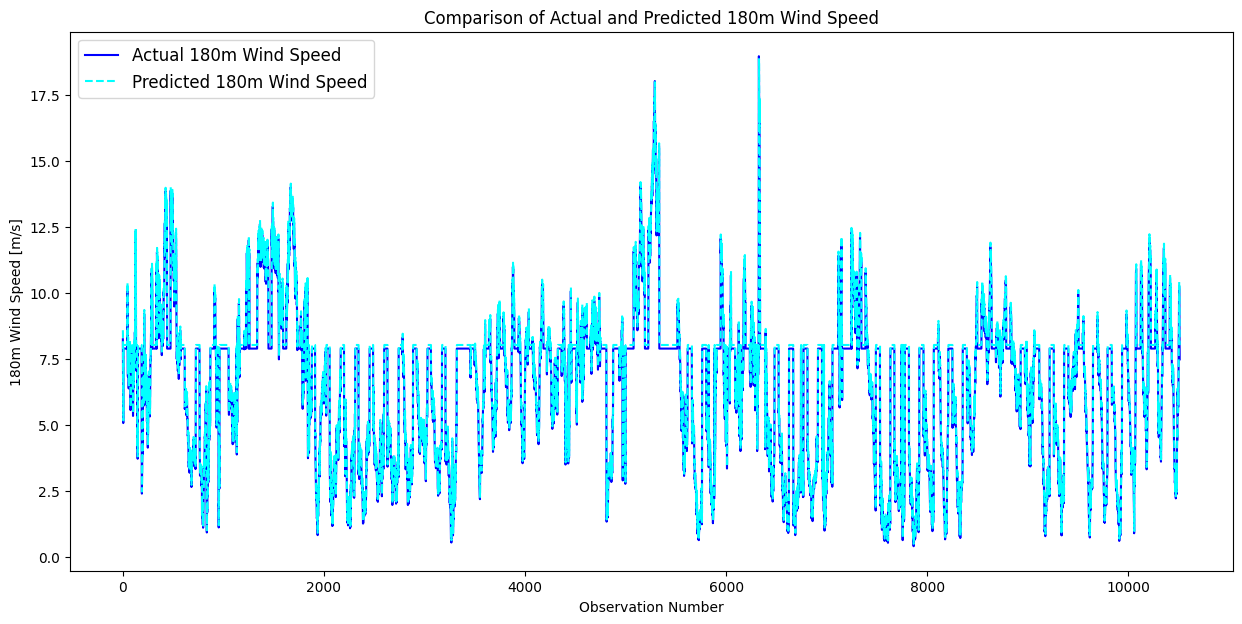

In [15]:
import matplotlib.pyplot as plt

# Generate a sequence of indices for plotting - adjust based on the number of test samples
indices = range(len(y_test_inv.flatten()))

# Plotting
plt.figure(figsize=(15, 7))
# Plotting the original dataset values
plt.plot(indices, y_test_inv.flatten(), label='Actual 180m Wind Speed', color='blue')
# Plotting the model predictions
plt.plot(indices, test_predict.flatten(), label='Predicted 180m Wind Speed', color='cyan', linestyle='--')

# Adding title and labels
plt.title('Comparison of Actual and Predicted 180m Wind Speed')
plt.xlabel('Observation Number')
plt.ylabel('180m Wind Speed [m/s]')

# Adding a legend
plt.legend(loc='upper left', fontsize='large')

plt.show()


# **200m**

In [16]:
from sklearn.impute import KNNImputer
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error

# Assuming 'df' is your DataFrame

n_neighbors = 5  # Number of neighbors to consider. Adjust based on your dataset size and characteristics

imputer = KNNImputer(n_neighbors=n_neighbors)
# It's recommended to normalize or standardize your data before using KNN imputation for better performance
# Here, we are imputing directly for simplicity
imputed_values = imputer.fit_transform(df7[['200m Wind Speed [m/s]']])

# Replace the original column with the imputed values
df7['200m Wind Speed [m/s]'] = imputed_values


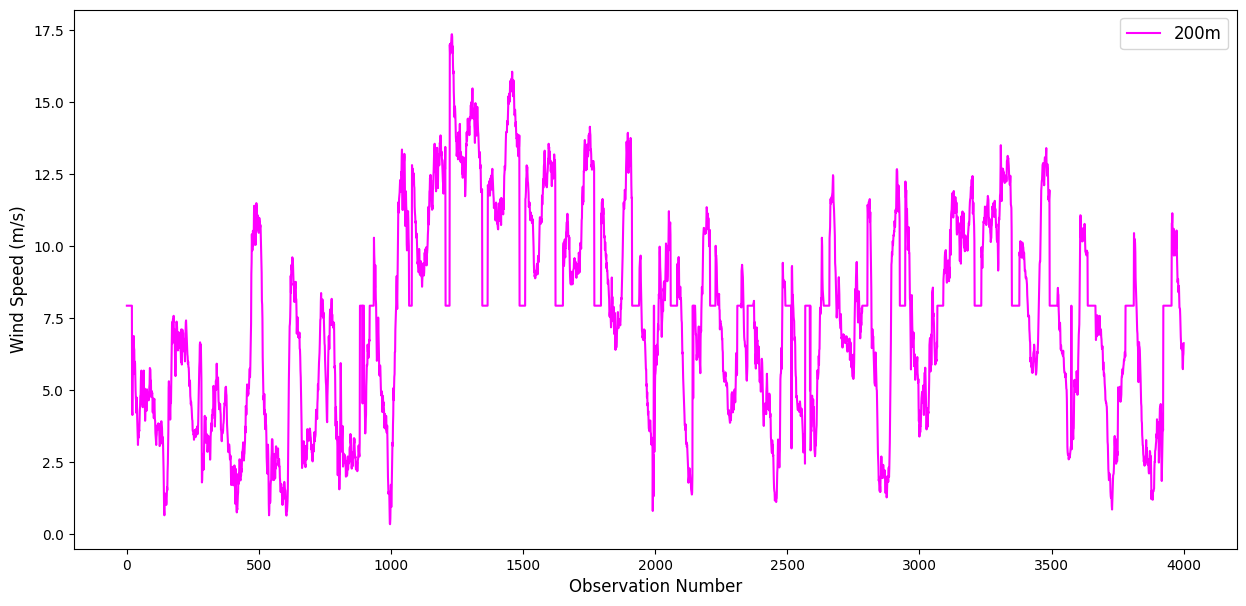

In [43]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it contains a column 'Wind Speed [m/s]' for wind speed
# Extracting the first 4000 observations
wind_speed_data = df7['200m Wind Speed [m/s]'][700:4700]

# Generating a sequence of observation numbers starting from 1
observation_numbers = range(1, 4001)

# Plotting the graph
plt.figure(figsize=(15, 7))  # Set the figure size as desired
plt.plot(observation_numbers, wind_speed_data, label='200m', color='magenta')  # Specify the color as needed

# Labeling the axes
plt.xlabel('Observation Number', fontsize='large')
plt.ylabel('Wind Speed (m/s)', fontsize='large')

# Adding the legend
plt.legend(fontsize = 'large')

# Optionally, you can adjust the tick frequency on the x-axis for better readability
plt.xticks(range(0, 4001, 500))

# Showing the plot
plt.show()

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_percentage_error

# Sample data loading step
# df = pd.read_csv('your_data.csv')  # Make sure to load your dataset here

# Assuming '40m Wind Speed [m/s]' is the column you're interested in
data = df7['200m Wind Speed [m/s]'].values.reshape(-1, 1)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Split data into training and test sets in an 80:20 ratio
split_idx = int(len(data_scaled) * 0.8)
train, test = data_scaled[:split_idx, :], data_scaled[split_idx:, :]

# Function to create dataset for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
model.fit(X_train, y_train, epochs=5, batch_size=2, verbose=2)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test])

# Calculate MAPE
mape_test = mean_absolute_percentage_error(y_test_inv.flatten(), test_predict.flatten()) * 100

print(f'Test MAPE: {mape_test:.4f}%')

from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Calculate MAE
mae_test = mean_absolute_error(y_test_inv.flatten(), test_predict.flatten())
print(f'Test MAE: {mae_test:.4f}')

# Calculate RMSE
rmse_test = sqrt(mean_squared_error(y_test_inv.flatten(), test_predict.flatten()))
print(f'Test RMSE: {rmse_test:.4f}')

from sklearn.metrics import r2_score

# Calculate R^2 score for the test set
r2_test = r2_score(y_test_inv.flatten(), test_predict.flatten())
print(f'Test R^2 Score: {r2_test:.4f}')



Epoch 1/5
21023/21023 - 41s - loss: 0.0013 - 41s/epoch - 2ms/step
Epoch 2/5
21023/21023 - 39s - loss: 0.0010 - 39s/epoch - 2ms/step
Epoch 3/5
21023/21023 - 40s - loss: 0.0010 - 40s/epoch - 2ms/step
Epoch 4/5
21023/21023 - 39s - loss: 0.0010 - 39s/epoch - 2ms/step
Epoch 5/5
21023/21023 - 40s - loss: 9.9580e-04 - 40s/epoch - 2ms/step
329/329 [==============================] - 1s 2ms/step
Test MAPE: 7.5407%
Test MAE: 0.3367
Test RMSE: 0.6975
Test R^2 Score: 0.9346


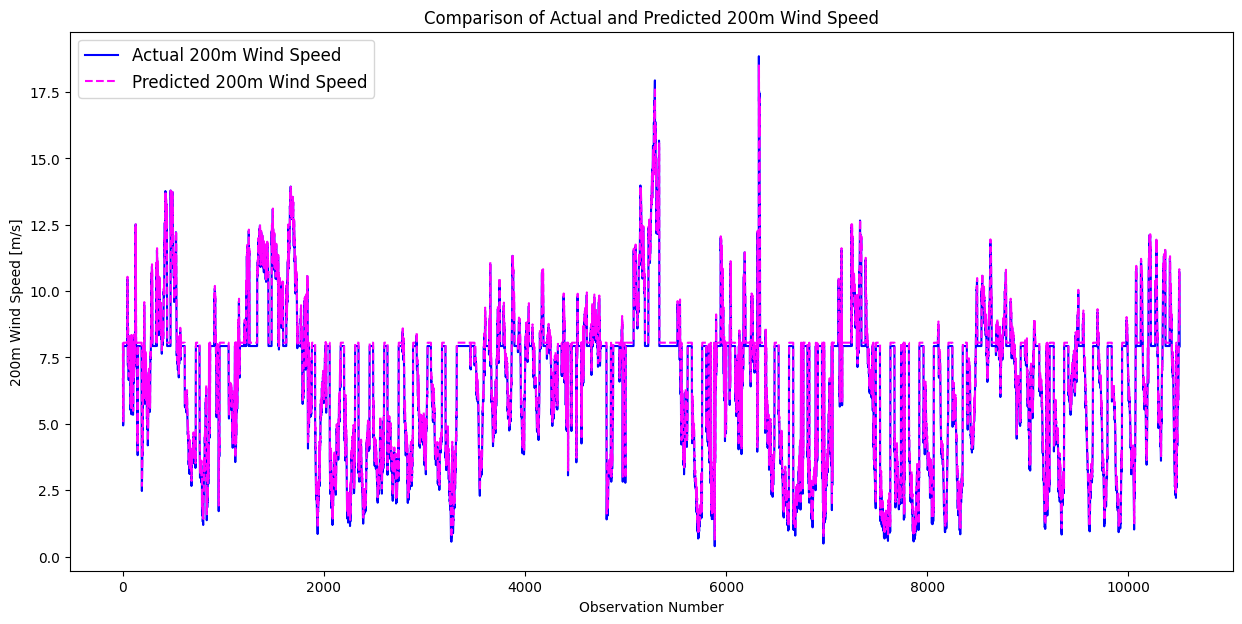

In [18]:
import matplotlib.pyplot as plt

# Generate a sequence of indices for plotting - adjust based on the number of test samples
indices = range(len(y_test_inv.flatten()))

# Plotting
plt.figure(figsize=(15, 7))
# Plotting the original dataset values
plt.plot(indices, y_test_inv.flatten(), label='Actual 200m Wind Speed', color='blue')
# Plotting the model predictions
plt.plot(indices, test_predict.flatten(), label='Predicted 200m Wind Speed', color='magenta', linestyle='--')

# Adding title and labels
plt.title('Comparison of Actual and Predicted 200m Wind Speed')
plt.xlabel('Observation Number')
plt.ylabel('200m Wind Speed [m/s]')

# Adding a legend
plt.legend(loc='upper left', fontsize='large')

plt.show()
